### Appendix E: Parameter-efficient Finetuning with LoRA

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
		"numpy",
		"tiktoken",
		"torch",
		"tensorflow", # For OpenAI's pretrained weights
		"pandas"      # Dataset loading
	   ]
for p in pkgs:
	print(f"{p} version: {version(p)}")

matplotlib version: 3.4.3
numpy version: 1.23.0
tiktoken version: 0.7.0
torch version: 2.4.1
tensorflow version: 2.13.1
pandas version: 2.0.3


### 2 Preparing the dataset

In [ ]:
import urllib
from pathlib import Path
import pandas as pd
from previous_chapters import (
	download_and_unzip_spam_data,
	create_balanced_dataset,
	random_split
)

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

try:
	download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
	print(f"Primary URL failed: {e}. Trying backup URL...")
	url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
	download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
 
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import torch
import tiktoken
from previous_chapters import SpamDataset


tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset("validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset("test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
	num_workers=num_workers,
	drop_last=True,
)

val_loader = DataLoader(
	dataset=val_dataset,
	batch_size=batch_size,
	num_workers=num_workers,
	drop_last=False,
)

test_loader = DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	num_workers=num_workers,
	drop_last=False,
)

In [ ]:
# 检查数据集
print("Train loader:")
for input_batch, target_batch in train_loader:
	pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


### 3 初始化模型

In [ ]:
import sys
sys.path.append("../ch05")

from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# Alternatively:
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import load_weights_into_gpt



CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
	"vocab_size": 50257,     # Vocabulary size
	"context_length": 1024,  # Context length
	"drop_rate": 0.0,        # Dropout rate
	"qkv_bias": True         # Query-key-value bias
}

model_configs = {
	"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
	"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
	"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
	"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="../ch05/gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: ../ch05/gpt2/124M/checkpoint
File already exists and is up-to-date: ../ch05/gpt2/124M/encoder.json
File already exists and is up-to-date: ../ch05/gpt2/124M/hparams.json
File already exists and is up-to-date: ../ch05/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../ch05/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../ch05/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../ch05/gpt2/124M/vocab.bpe


In [ ]:
# 测试模型加载
from previous_chapters import (
	generate_text_simple,
	text_to_token_ids,
	token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
	model=model,
	idx=text_to_token_ids(text_1, tokenizer),
	max_new_tokens=15,
	context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [11]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [13]:
# 未经微调模型测试
from previous_chapters import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### 4 Parameter-efficient finetuning with LoRA

- 创建LoRA层

In [ ]:
import math

class LoRALayer(torch.nn.Module):
	def __init__(self, in_dim, out_dim, rank, alpha):
		super().__init__()
		self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
		torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))	# 类似于标准的权重初始化
		self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
		self.alpha = alpha
	
	def forward(self, x):
		x = self.alpha * (x @ self.A @ self.B)
		return x

- LinearWithLoRA 可以替换所有的线性 

In [ ]:
class LinearWithLoRA(torch.nn.Module):
	def __init__(self, linear, rank, alpha):
		super().__init__()
		self.linear = linear
		self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

	def forward(self, x):
		return self.linear(x) + self.lora(x)

In [ ]:
def replace_linear_with_lora(model, rank, alpha):
	for name, module in model.named_children():	# 遍历所有直接下属层
		if isinstance(module, torch.nn.Linear):
			# 将Linear换成带LoRA版本的
			setattr(model, name, LinearWithLoRA(module, rank, alpha))
		else:
			# 递归调用
			replace_linear_with_lora(module, rank, alpha)

In [ ]:
# 冻结参数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
	param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [24]:
# 换LoRA
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [ ]:
# 由于初始化化B=0
# 故未经训练结果不变
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [27]:
# 训练
import time
from previous_chapters import train_classifier_simple

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
	model, train_loader, val_loader, optimizer, device,
	num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.008, Val loss 0.050
Ep 2 (Step 000250): Train loss 0.022, Val loss 0.179
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.088, Val loss 0.043
Ep 3 (Step 000350): Train loss 0.023, Val loss 0.184
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.038, Val loss 0.017
Ep 4 (Step 000450): Train loss 0.014, Val loss 0.070
Ep 4 (Step 000500): Train loss 0.000, Val loss 0.131
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.009, Val loss 0.118
Ep 5 (Step 000600): Train loss 0.007, Val loss 0.266
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 1.59 m

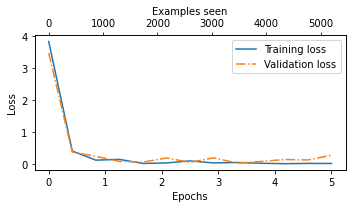

In [28]:
from previous_chapters import plot_values

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

In [29]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.52%
Validation accuracy: 97.99%
Test accuracy: 98.00%


In [30]:
# 保存权重
torch.save(model.state_dict(), "LoRA_classifier.pth")